In [81]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
class NodeFeatureLSTM(nn.Module):
    def __init__(self, feature_size, hidden_size):
        super(NodeFeatureLSTM, self).__init__()
        self.lstm = nn.LSTM(feature_size, hidden_size, batch_first=True)

    def forward(self, features):
        # features: [batch_size, seq_length, feature_size]
        _, (h_n, _) = self.lstm(features)
        # h_n: [1, batch_size, hidden_size]
        return h_n.squeeze(0)

class DynamicGCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(DynamicGCN, self).__init__()
        self.lstm = NodeFeatureLSTM(in_feats, h_feats)
        self.conv1 = GraphConv(h_feats, h_feats)
        self.fc = nn.Linear(h_feats, 1)  

    def forward(self, g, in_feat_seq):
        # LSTM Process node features
        # suppose in_feat_seq is a shape of [num_nodes, seq_length, in_feats] tensor
        lstm_out = torch.stack([self.lstm(in_feat_seq[i]) for i in range(g.num_nodes())])
        h = self.conv1(g, lstm_out)
        h = F.relu(h)
        h = self.conv1(g, h)
        h = self.fc(h) 
        return h

In [2]:
df = pd.read_csv('./stock.csv')

In [3]:
comps = ["AAPL", "MSFT", "GOOGL", "NVDA", "AMZN"]
import scipy.sparse as sp

data = np.genfromtxt('weight.csv', delimiter=',', skip_header=0, dtype = int)  # 假设第一行是标题
data = sp.coo_matrix(data)
data

<5x5 sparse matrix of type '<class 'numpy.int32'>'
	with 25 stored elements in COOrdinate format>

In [4]:
g = dgl.from_scipy(data)
g = dgl.add_self_loop(g)

In [5]:
 
all_features = []

for item in comps:
    # 对每个公司，提取其特征并转换为张量
    tmp_features = df[[item+'_Open', item+'_High', item+'_Low', item+'_Close', item+'_Volume']]
    company_tensor = torch.tensor(tmp_features.values, dtype=torch.float32)  # 转换为浮点数张量
    all_features.append(company_tensor)

# 使用 torch.stack 将所有公司的特征堆叠到一起
final_feature = torch.stack(all_features)

In [8]:
final_feature.shape

torch.Size([5, 251, 5])

In [9]:
g.edges[25]

EdgeSpace(data={})

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# 将张量转换为 NumPy 数组
final_feature_np = final_feature.numpy()

# 重新排列数组维度
final_feature_np_transposed = np.transpose(final_feature_np, (0, 2, 1))  # 形状变为 (5, 5, 251)

# 重塑数组以适应 MinMaxScaler
final_feature_reshaped = final_feature_np_transposed.reshape(-1, final_feature_np_transposed.shape[-1])

# 创建归一化器并归一化数据
scaler = MinMaxScaler()
final_feature_scaled = scaler.fit_transform(final_feature_reshaped)

# 将数据转换回原始的维度排列并重塑
final_feature_scaled = final_feature_scaled.reshape(final_feature_np_transposed.shape)
final_feature_scaled_transposed = np.transpose(final_feature_scaled, (0, 2, 1))  # 形状变为 (5, 251, 5)

# 将 NumPy 数组转换回 PyTorch 张量
final_feature_scaled_tensor = torch.tensor(final_feature_scaled_transposed)

In [39]:
final_feature_scaled_tensor[1][110]

tensor([1.6549e-06, 1.6549e-06, 1.5669e-06, 1.5720e-06, 3.4342e-01])

In [16]:


def create_dataset(dataset, window_size = 14):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i+window_size])
        y.append(dataset[i+window_size])
    return np.array(X), np.array(y)

batch = []
target = []
window_size = 14
for i in range(237):
    tmp = []
    tar_tmp = []
    for j in range(5):
        tmp.append(final_feature_scaled_tensor[j][i:i+window_size][:])
        tar_tmp.append(final_feature_scaled_tensor[j][i+window_size][0])
    target.append(tar_tmp)
    batch.append(tmp)


In [26]:
torch.tensor(target[0])

tensor([2.1831e-07, 1.0307e-06, 9.0839e-09, 6.0723e-07, 8.9118e-08])

In [90]:
# 初始化图和模型
feature_size = 5
hidden_size = 48
seq_length = 14

node_features_seq = torch.randn(5, seq_length, feature_size)
model = DynamicGCN(feature_size, hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 创建合成目标数据
#targets = torch.randn(5, 1)  # 假设每个节点有一个目标值

# 训练循环
losses = []
predictions = []
true = []
for i in range(5):
    for epoch in range(215):
        for j in range(len(target[epoch])):
            model.train()
            pred = model(g, batch[epoch])
            loss = F.mse_loss(pred, torch.tensor(target[epoch]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            predictions.append(pred.detach().numpy())
            true.append(target[epoch])
            print(loss)


C:\Users\LiuQingyuan\AppData\Local\Temp\ipykernel_9960\3824289898.py:22: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred, torch.tensor(target[epoch]))


tensor(0.0051, grad_fn=<MseLossBackward0>)
tensor(0.0167, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(7.2730e-05, grad_fn=<MseLossBackward0>)
tensor(9.4277e-06, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(3.2367e-05, grad_fn=<MseLossBackward0>)
tensor(1.9106e-06, grad_fn=<MseLossBackward0>)
tensor(5.6739e-05, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(6.9340e-05, grad_fn=<MseLossBackward0>)
tensor(1.5818e-05, grad_fn=<Ms

tensor(1.9722e-08, grad_fn=<MseLossBackward0>)
tensor(2.2584e-08, grad_fn=<MseLossBackward0>)
tensor(4.7168e-10, grad_fn=<MseLossBackward0>)
tensor(2.7903e-08, grad_fn=<MseLossBackward0>)
tensor(4.9526e-08, grad_fn=<MseLossBackward0>)
tensor(2.9456e-08, grad_fn=<MseLossBackward0>)
tensor(8.6922e-09, grad_fn=<MseLossBackward0>)
tensor(2.6505e-08, grad_fn=<MseLossBackward0>)
tensor(2.2638e-08, grad_fn=<MseLossBackward0>)
tensor(4.8550e-09, grad_fn=<MseLossBackward0>)
tensor(1.2624e-09, grad_fn=<MseLossBackward0>)
tensor(7.3346e-10, grad_fn=<MseLossBackward0>)
tensor(3.2004e-09, grad_fn=<MseLossBackward0>)
tensor(1.1127e-08, grad_fn=<MseLossBackward0>)
tensor(9.9926e-09, grad_fn=<MseLossBackward0>)
tensor(2.2823e-09, grad_fn=<MseLossBackward0>)
tensor(2.9213e-10, grad_fn=<MseLossBackward0>)
tensor(5.1749e-09, grad_fn=<MseLossBackward0>)
tensor(7.5926e-09, grad_fn=<MseLossBackward0>)
tensor(3.5012e-09, grad_fn=<MseLossBackward0>)
tensor(3.1409e-11, grad_fn=<MseLossBackward0>)
tensor(2.3585

tensor(7.1182e-09, grad_fn=<MseLossBackward0>)
tensor(1.5272e-10, grad_fn=<MseLossBackward0>)
tensor(3.6962e-09, grad_fn=<MseLossBackward0>)
tensor(7.4418e-09, grad_fn=<MseLossBackward0>)
tensor(2.6706e-09, grad_fn=<MseLossBackward0>)
tensor(1.2113e-09, grad_fn=<MseLossBackward0>)
tensor(5.0016e-09, grad_fn=<MseLossBackward0>)
tensor(3.1131e-09, grad_fn=<MseLossBackward0>)
tensor(2.4548e-11, grad_fn=<MseLossBackward0>)
tensor(1.9576e-09, grad_fn=<MseLossBackward0>)
tensor(6.1520e-09, grad_fn=<MseLossBackward0>)
tensor(1.4933e-09, grad_fn=<MseLossBackward0>)
tensor(5.4484e-10, grad_fn=<MseLossBackward0>)
tensor(4.0201e-09, grad_fn=<MseLossBackward0>)
tensor(3.2017e-09, grad_fn=<MseLossBackward0>)
tensor(8.6227e-10, grad_fn=<MseLossBackward0>)
tensor(2.4556e-09, grad_fn=<MseLossBackward0>)
tensor(1.1528e-09, grad_fn=<MseLossBackward0>)
tensor(1.1117e-11, grad_fn=<MseLossBackward0>)
tensor(1.1987e-09, grad_fn=<MseLossBackward0>)
tensor(1.1650e-09, grad_fn=<MseLossBackward0>)
tensor(4.3138

tensor(5.0785e-11, grad_fn=<MseLossBackward0>)
tensor(7.6168e-09, grad_fn=<MseLossBackward0>)
tensor(7.1540e-09, grad_fn=<MseLossBackward0>)
tensor(8.9213e-11, grad_fn=<MseLossBackward0>)
tensor(4.4155e-09, grad_fn=<MseLossBackward0>)
tensor(1.0977e-08, grad_fn=<MseLossBackward0>)
tensor(5.8003e-10, grad_fn=<MseLossBackward0>)
tensor(4.8214e-09, grad_fn=<MseLossBackward0>)
tensor(8.7542e-09, grad_fn=<MseLossBackward0>)
tensor(1.1702e-09, grad_fn=<MseLossBackward0>)
tensor(6.3051e-09, grad_fn=<MseLossBackward0>)
tensor(7.2700e-09, grad_fn=<MseLossBackward0>)
tensor(2.6212e-10, grad_fn=<MseLossBackward0>)
tensor(3.6206e-09, grad_fn=<MseLossBackward0>)
tensor(5.8379e-09, grad_fn=<MseLossBackward0>)
tensor(1.5701e-10, grad_fn=<MseLossBackward0>)
tensor(2.3605e-09, grad_fn=<MseLossBackward0>)
tensor(1.4764e-09, grad_fn=<MseLossBackward0>)
tensor(2.0940e-11, grad_fn=<MseLossBackward0>)
tensor(1.5386e-09, grad_fn=<MseLossBackward0>)
tensor(8.4446e-10, grad_fn=<MseLossBackward0>)
tensor(4.0349

tensor(2.3878e-10, grad_fn=<MseLossBackward0>)
tensor(8.1577e-08, grad_fn=<MseLossBackward0>)
tensor(1.8939e-09, grad_fn=<MseLossBackward0>)
tensor(4.8312e-08, grad_fn=<MseLossBackward0>)
tensor(5.2655e-08, grad_fn=<MseLossBackward0>)
tensor(1.0107e-12, grad_fn=<MseLossBackward0>)
tensor(8.1603e-08, grad_fn=<MseLossBackward0>)
tensor(3.1242e-08, grad_fn=<MseLossBackward0>)
tensor(1.0852e-08, grad_fn=<MseLossBackward0>)
tensor(6.2227e-08, grad_fn=<MseLossBackward0>)
tensor(1.4685e-08, grad_fn=<MseLossBackward0>)
tensor(1.6519e-08, grad_fn=<MseLossBackward0>)
tensor(4.5115e-08, grad_fn=<MseLossBackward0>)
tensor(4.5775e-09, grad_fn=<MseLossBackward0>)
tensor(1.7742e-08, grad_fn=<MseLossBackward0>)
tensor(3.0764e-08, grad_fn=<MseLossBackward0>)
tensor(4.1017e-09, grad_fn=<MseLossBackward0>)
tensor(1.7796e-08, grad_fn=<MseLossBackward0>)
tensor(2.9577e-08, grad_fn=<MseLossBackward0>)
tensor(7.3665e-10, grad_fn=<MseLossBackward0>)
tensor(1.7386e-08, grad_fn=<MseLossBackward0>)
tensor(2.1350

tensor(6.3598e-08, grad_fn=<MseLossBackward0>)
tensor(6.3069e-08, grad_fn=<MseLossBackward0>)
tensor(3.1027e-09, grad_fn=<MseLossBackward0>)
tensor(1.2791e-07, grad_fn=<MseLossBackward0>)
tensor(1.1278e-08, grad_fn=<MseLossBackward0>)
tensor(6.2636e-08, grad_fn=<MseLossBackward0>)
tensor(6.9954e-08, grad_fn=<MseLossBackward0>)
tensor(2.2220e-09, grad_fn=<MseLossBackward0>)
tensor(3.4871e-08, grad_fn=<MseLossBackward0>)
tensor(2.4878e-08, grad_fn=<MseLossBackward0>)
tensor(3.8897e-09, grad_fn=<MseLossBackward0>)
tensor(3.3792e-08, grad_fn=<MseLossBackward0>)
tensor(4.5362e-09, grad_fn=<MseLossBackward0>)
tensor(2.2275e-08, grad_fn=<MseLossBackward0>)
tensor(1.8032e-08, grad_fn=<MseLossBackward0>)
tensor(2.0385e-09, grad_fn=<MseLossBackward0>)
tensor(2.2769e-08, grad_fn=<MseLossBackward0>)
tensor(3.5704e-09, grad_fn=<MseLossBackward0>)
tensor(1.3440e-08, grad_fn=<MseLossBackward0>)
tensor(1.2718e-08, grad_fn=<MseLossBackward0>)
tensor(9.0541e-10, grad_fn=<MseLossBackward0>)
tensor(1.4728

tensor(9.7625e-08, grad_fn=<MseLossBackward0>)
tensor(3.5644e-08, grad_fn=<MseLossBackward0>)
tensor(1.3708e-07, grad_fn=<MseLossBackward0>)
tensor(3.1283e-11, grad_fn=<MseLossBackward0>)
tensor(1.0983e-07, grad_fn=<MseLossBackward0>)
tensor(1.0333e-08, grad_fn=<MseLossBackward0>)
tensor(1.2470e-08, grad_fn=<MseLossBackward0>)
tensor(1.4439e-09, grad_fn=<MseLossBackward0>)
tensor(1.4104e-08, grad_fn=<MseLossBackward0>)
tensor(4.9420e-10, grad_fn=<MseLossBackward0>)
tensor(2.5881e-07, grad_fn=<MseLossBackward0>)
tensor(9.7856e-09, grad_fn=<MseLossBackward0>)
tensor(2.5799e-07, grad_fn=<MseLossBackward0>)
tensor(2.4856e-08, grad_fn=<MseLossBackward0>)
tensor(1.4402e-07, grad_fn=<MseLossBackward0>)
tensor(8.1524e-08, grad_fn=<MseLossBackward0>)
tensor(2.6461e-08, grad_fn=<MseLossBackward0>)
tensor(1.1323e-07, grad_fn=<MseLossBackward0>)
tensor(2.5086e-10, grad_fn=<MseLossBackward0>)
tensor(8.6977e-08, grad_fn=<MseLossBackward0>)
tensor(1.6186e-08, grad_fn=<MseLossBackward0>)
tensor(4.7771

tensor(2.4579e-08, grad_fn=<MseLossBackward0>)
tensor(1.9910e-08, grad_fn=<MseLossBackward0>)
tensor(1.8729e-09, grad_fn=<MseLossBackward0>)
tensor(1.9661e-08, grad_fn=<MseLossBackward0>)
tensor(9.4661e-12, grad_fn=<MseLossBackward0>)
tensor(1.5697e-08, grad_fn=<MseLossBackward0>)
tensor(5.1025e-08, grad_fn=<MseLossBackward0>)
tensor(4.4005e-08, grad_fn=<MseLossBackward0>)
tensor(7.1580e-08, grad_fn=<MseLossBackward0>)
tensor(1.1632e-08, grad_fn=<MseLossBackward0>)
tensor(7.4867e-08, grad_fn=<MseLossBackward0>)
tensor(8.9128e-09, grad_fn=<MseLossBackward0>)
tensor(4.0760e-08, grad_fn=<MseLossBackward0>)
tensor(6.4646e-10, grad_fn=<MseLossBackward0>)
tensor(3.5795e-08, grad_fn=<MseLossBackward0>)
tensor(1.1197e-09, grad_fn=<MseLossBackward0>)
tensor(1.8523e-08, grad_fn=<MseLossBackward0>)
tensor(8.4846e-09, grad_fn=<MseLossBackward0>)
tensor(9.1244e-09, grad_fn=<MseLossBackward0>)
tensor(1.2324e-08, grad_fn=<MseLossBackward0>)
tensor(2.8620e-09, grad_fn=<MseLossBackward0>)
tensor(5.6576

tensor(1.9849e-10, grad_fn=<MseLossBackward0>)
tensor(3.6295e-08, grad_fn=<MseLossBackward0>)
tensor(3.5113e-09, grad_fn=<MseLossBackward0>)
tensor(3.1820e-08, grad_fn=<MseLossBackward0>)
tensor(1.0458e-09, grad_fn=<MseLossBackward0>)
tensor(2.7047e-08, grad_fn=<MseLossBackward0>)
tensor(1.3458e-08, grad_fn=<MseLossBackward0>)
tensor(6.2747e-08, grad_fn=<MseLossBackward0>)
tensor(1.7188e-08, grad_fn=<MseLossBackward0>)
tensor(4.5026e-08, grad_fn=<MseLossBackward0>)
tensor(1.9325e-08, grad_fn=<MseLossBackward0>)
tensor(4.0731e-08, grad_fn=<MseLossBackward0>)
tensor(1.5286e-08, grad_fn=<MseLossBackward0>)
tensor(2.8711e-08, grad_fn=<MseLossBackward0>)
tensor(1.6295e-08, grad_fn=<MseLossBackward0>)
tensor(1.9686e-08, grad_fn=<MseLossBackward0>)
tensor(1.0185e-07, grad_fn=<MseLossBackward0>)
tensor(6.9225e-08, grad_fn=<MseLossBackward0>)
tensor(9.8981e-08, grad_fn=<MseLossBackward0>)
tensor(4.2123e-08, grad_fn=<MseLossBackward0>)
tensor(9.2769e-08, grad_fn=<MseLossBackward0>)
tensor(1.9483

tensor(2.9853e-09, grad_fn=<MseLossBackward0>)
tensor(6.2889e-09, grad_fn=<MseLossBackward0>)
tensor(7.3692e-10, grad_fn=<MseLossBackward0>)
tensor(5.5062e-09, grad_fn=<MseLossBackward0>)
tensor(2.8145e-10, grad_fn=<MseLossBackward0>)
tensor(4.7096e-09, grad_fn=<MseLossBackward0>)
tensor(2.7379e-09, grad_fn=<MseLossBackward0>)
tensor(6.0758e-12, grad_fn=<MseLossBackward0>)
tensor(2.2445e-09, grad_fn=<MseLossBackward0>)
tensor(9.6837e-12, grad_fn=<MseLossBackward0>)
tensor(1.7929e-09, grad_fn=<MseLossBackward0>)
tensor(1.0680e-09, grad_fn=<MseLossBackward0>)
tensor(6.0171e-09, grad_fn=<MseLossBackward0>)
tensor(4.3895e-10, grad_fn=<MseLossBackward0>)
tensor(5.2028e-09, grad_fn=<MseLossBackward0>)
tensor(1.2017e-10, grad_fn=<MseLossBackward0>)
tensor(3.4598e-10, grad_fn=<MseLossBackward0>)
tensor(7.7586e-09, grad_fn=<MseLossBackward0>)
tensor(5.1145e-11, grad_fn=<MseLossBackward0>)
tensor(6.4121e-09, grad_fn=<MseLossBackward0>)
tensor(6.1034e-12, grad_fn=<MseLossBackward0>)
tensor(3.2068

tensor(2.1380e-09, grad_fn=<MseLossBackward0>)
tensor(1.0279e-07, grad_fn=<MseLossBackward0>)
tensor(1.0315e-08, grad_fn=<MseLossBackward0>)
tensor(8.2794e-08, grad_fn=<MseLossBackward0>)
tensor(3.0937e-08, grad_fn=<MseLossBackward0>)
tensor(4.3333e-08, grad_fn=<MseLossBackward0>)
tensor(4.7787e-08, grad_fn=<MseLossBackward0>)
tensor(5.8393e-09, grad_fn=<MseLossBackward0>)
tensor(3.1333e-08, grad_fn=<MseLossBackward0>)
tensor(3.1343e-10, grad_fn=<MseLossBackward0>)
tensor(2.7122e-08, grad_fn=<MseLossBackward0>)
tensor(1.0756e-09, grad_fn=<MseLossBackward0>)
tensor(8.5561e-08, grad_fn=<MseLossBackward0>)
tensor(6.2853e-08, grad_fn=<MseLossBackward0>)
tensor(3.6529e-08, grad_fn=<MseLossBackward0>)
tensor(7.8832e-08, grad_fn=<MseLossBackward0>)
tensor(8.5299e-09, grad_fn=<MseLossBackward0>)
tensor(2.0730e-07, grad_fn=<MseLossBackward0>)
tensor(4.6015e-08, grad_fn=<MseLossBackward0>)
tensor(1.1889e-07, grad_fn=<MseLossBackward0>)
tensor(8.8013e-08, grad_fn=<MseLossBackward0>)
tensor(4.7915

tensor(4.6371e-08, grad_fn=<MseLossBackward0>)
tensor(1.1988e-08, grad_fn=<MseLossBackward0>)
tensor(6.2364e-08, grad_fn=<MseLossBackward0>)
tensor(8.9309e-10, grad_fn=<MseLossBackward0>)
tensor(9.7290e-09, grad_fn=<MseLossBackward0>)
tensor(4.7620e-10, grad_fn=<MseLossBackward0>)
tensor(1.0057e-08, grad_fn=<MseLossBackward0>)
tensor(1.1008e-09, grad_fn=<MseLossBackward0>)
tensor(5.3044e-09, grad_fn=<MseLossBackward0>)
tensor(5.2042e-12, grad_fn=<MseLossBackward0>)
tensor(1.5329e-08, grad_fn=<MseLossBackward0>)
tensor(4.5103e-09, grad_fn=<MseLossBackward0>)
tensor(5.8064e-09, grad_fn=<MseLossBackward0>)
tensor(1.0120e-08, grad_fn=<MseLossBackward0>)
tensor(1.8433e-09, grad_fn=<MseLossBackward0>)
tensor(2.4196e-10, grad_fn=<MseLossBackward0>)
tensor(2.1952e-09, grad_fn=<MseLossBackward0>)
tensor(1.1658e-10, grad_fn=<MseLossBackward0>)
tensor(1.3312e-09, grad_fn=<MseLossBackward0>)
tensor(1.2567e-08, grad_fn=<MseLossBackward0>)
tensor(1.0496e-08, grad_fn=<MseLossBackward0>)
tensor(2.0891

tensor(8.2970e-09, grad_fn=<MseLossBackward0>)
tensor(5.7168e-09, grad_fn=<MseLossBackward0>)
tensor(1.8723e-08, grad_fn=<MseLossBackward0>)
tensor(1.6090e-09, grad_fn=<MseLossBackward0>)
tensor(7.3626e-09, grad_fn=<MseLossBackward0>)
tensor(9.7449e-09, grad_fn=<MseLossBackward0>)
tensor(2.9051e-11, grad_fn=<MseLossBackward0>)
tensor(8.6226e-09, grad_fn=<MseLossBackward0>)
tensor(1.8244e-07, grad_fn=<MseLossBackward0>)
tensor(2.9482e-07, grad_fn=<MseLossBackward0>)
tensor(3.2888e-12, grad_fn=<MseLossBackward0>)
tensor(2.3662e-07, grad_fn=<MseLossBackward0>)
tensor(1.1629e-07, grad_fn=<MseLossBackward0>)
tensor(1.8659e-08, grad_fn=<MseLossBackward0>)
tensor(7.4051e-09, grad_fn=<MseLossBackward0>)
tensor(4.1223e-09, grad_fn=<MseLossBackward0>)
tensor(1.4728e-08, grad_fn=<MseLossBackward0>)
tensor(6.2597e-10, grad_fn=<MseLossBackward0>)
tensor(8.5657e-08, grad_fn=<MseLossBackward0>)
tensor(1.6706e-07, grad_fn=<MseLossBackward0>)
tensor(4.1862e-10, grad_fn=<MseLossBackward0>)
tensor(1.2553

tensor(8.3253e-08, grad_fn=<MseLossBackward0>)
tensor(7.6286e-10, grad_fn=<MseLossBackward0>)
tensor(8.2024e-08, grad_fn=<MseLossBackward0>)
tensor(3.4724e-08, grad_fn=<MseLossBackward0>)
tensor(1.8622e-08, grad_fn=<MseLossBackward0>)
tensor(8.9291e-08, grad_fn=<MseLossBackward0>)
tensor(2.7577e-08, grad_fn=<MseLossBackward0>)
tensor(1.1966e-08, grad_fn=<MseLossBackward0>)
tensor(5.6297e-08, grad_fn=<MseLossBackward0>)
tensor(1.3277e-08, grad_fn=<MseLossBackward0>)
tensor(1.0521e-08, grad_fn=<MseLossBackward0>)
tensor(4.1117e-08, grad_fn=<MseLossBackward0>)
tensor(1.0920e-08, grad_fn=<MseLossBackward0>)
tensor(1.3649e-08, grad_fn=<MseLossBackward0>)
tensor(5.7018e-08, grad_fn=<MseLossBackward0>)
tensor(1.6103e-08, grad_fn=<MseLossBackward0>)
tensor(8.4925e-09, grad_fn=<MseLossBackward0>)
tensor(4.1488e-08, grad_fn=<MseLossBackward0>)
tensor(2.5294e-08, grad_fn=<MseLossBackward0>)
tensor(9.3077e-11, grad_fn=<MseLossBackward0>)
tensor(1.7948e-08, grad_fn=<MseLossBackward0>)
tensor(1.9365

tensor(8.4694e-08, grad_fn=<MseLossBackward0>)
tensor(2.4138e-10, grad_fn=<MseLossBackward0>)
tensor(9.6565e-08, grad_fn=<MseLossBackward0>)
tensor(1.0628e-07, grad_fn=<MseLossBackward0>)
tensor(6.4853e-09, grad_fn=<MseLossBackward0>)
tensor(4.1883e-08, grad_fn=<MseLossBackward0>)
tensor(1.3036e-07, grad_fn=<MseLossBackward0>)
tensor(7.5680e-08, grad_fn=<MseLossBackward0>)
tensor(4.3251e-10, grad_fn=<MseLossBackward0>)
tensor(7.3487e-08, grad_fn=<MseLossBackward0>)
tensor(8.0616e-08, grad_fn=<MseLossBackward0>)
tensor(3.0461e-08, grad_fn=<MseLossBackward0>)
tensor(1.1690e-09, grad_fn=<MseLossBackward0>)
tensor(1.4046e-08, grad_fn=<MseLossBackward0>)
tensor(2.6991e-08, grad_fn=<MseLossBackward0>)
tensor(6.2876e-09, grad_fn=<MseLossBackward0>)
tensor(5.9532e-09, grad_fn=<MseLossBackward0>)
tensor(3.0802e-08, grad_fn=<MseLossBackward0>)
tensor(1.6785e-08, grad_fn=<MseLossBackward0>)
tensor(1.3399e-10, grad_fn=<MseLossBackward0>)
tensor(1.6858e-08, grad_fn=<MseLossBackward0>)
tensor(8.5362

tensor(1.1488e-09, grad_fn=<MseLossBackward0>)
tensor(2.2920e-08, grad_fn=<MseLossBackward0>)
tensor(4.2464e-08, grad_fn=<MseLossBackward0>)
tensor(2.1928e-08, grad_fn=<MseLossBackward0>)
tensor(3.3083e-10, grad_fn=<MseLossBackward0>)
tensor(1.1734e-08, grad_fn=<MseLossBackward0>)
tensor(5.4024e-08, grad_fn=<MseLossBackward0>)
tensor(7.8962e-08, grad_fn=<MseLossBackward0>)
tensor(3.1885e-08, grad_fn=<MseLossBackward0>)
tensor(5.8806e-11, grad_fn=<MseLossBackward0>)
tensor(2.9389e-08, grad_fn=<MseLossBackward0>)
tensor(2.1128e-08, grad_fn=<MseLossBackward0>)
tensor(8.5914e-10, grad_fn=<MseLossBackward0>)
tensor(2.9524e-08, grad_fn=<MseLossBackward0>)
tensor(4.5761e-08, grad_fn=<MseLossBackward0>)
tensor(2.0562e-08, grad_fn=<MseLossBackward0>)
tensor(1.0726e-08, grad_fn=<MseLossBackward0>)
tensor(1.0099e-08, grad_fn=<MseLossBackward0>)
tensor(2.1606e-09, grad_fn=<MseLossBackward0>)
tensor(6.7076e-10, grad_fn=<MseLossBackward0>)
tensor(6.0680e-09, grad_fn=<MseLossBackward0>)
tensor(9.3465

tensor(5.3004e-09, grad_fn=<MseLossBackward0>)
tensor(1.8871e-08, grad_fn=<MseLossBackward0>)
tensor(2.2303e-08, grad_fn=<MseLossBackward0>)
tensor(1.1982e-08, grad_fn=<MseLossBackward0>)
tensor(1.3755e-09, grad_fn=<MseLossBackward0>)
tensor(2.5586e-08, grad_fn=<MseLossBackward0>)
tensor(1.5169e-07, grad_fn=<MseLossBackward0>)
tensor(2.1558e-07, grad_fn=<MseLossBackward0>)
tensor(1.3577e-07, grad_fn=<MseLossBackward0>)
tensor(2.5042e-08, grad_fn=<MseLossBackward0>)
tensor(2.8030e-09, grad_fn=<MseLossBackward0>)
tensor(4.2697e-09, grad_fn=<MseLossBackward0>)
tensor(3.0764e-09, grad_fn=<MseLossBackward0>)
tensor(8.3561e-10, grad_fn=<MseLossBackward0>)
tensor(1.8324e-11, grad_fn=<MseLossBackward0>)
tensor(1.6554e-09, grad_fn=<MseLossBackward0>)
tensor(4.6085e-09, grad_fn=<MseLossBackward0>)
tensor(5.0412e-09, grad_fn=<MseLossBackward0>)
tensor(2.6760e-09, grad_fn=<MseLossBackward0>)
tensor(3.3406e-10, grad_fn=<MseLossBackward0>)
tensor(3.9215e-09, grad_fn=<MseLossBackward0>)
tensor(2.3976

tensor(1.6472e-08, grad_fn=<MseLossBackward0>)
tensor(9.4582e-10, grad_fn=<MseLossBackward0>)
tensor(3.5247e-11, grad_fn=<MseLossBackward0>)
tensor(2.1021e-10, grad_fn=<MseLossBackward0>)
tensor(8.9260e-10, grad_fn=<MseLossBackward0>)
tensor(1.4158e-09, grad_fn=<MseLossBackward0>)
tensor(1.3642e-09, grad_fn=<MseLossBackward0>)
tensor(4.5547e-08, grad_fn=<MseLossBackward0>)
tensor(3.8811e-07, grad_fn=<MseLossBackward0>)
tensor(7.8461e-07, grad_fn=<MseLossBackward0>)
tensor(9.8921e-07, grad_fn=<MseLossBackward0>)
tensor(8.3775e-07, grad_fn=<MseLossBackward0>)
tensor(6.7750e-07, grad_fn=<MseLossBackward0>)
tensor(4.6667e-07, grad_fn=<MseLossBackward0>)
tensor(1.9066e-07, grad_fn=<MseLossBackward0>)
tensor(1.6605e-08, grad_fn=<MseLossBackward0>)
tensor(2.9909e-08, grad_fn=<MseLossBackward0>)
tensor(4.5823e-07, grad_fn=<MseLossBackward0>)
tensor(1.4656e-06, grad_fn=<MseLossBackward0>)
tensor(2.0451e-06, grad_fn=<MseLossBackward0>)
tensor(1.5604e-06, grad_fn=<MseLossBackward0>)
tensor(6.4710

tensor(4.5066e-07, grad_fn=<MseLossBackward0>)
tensor(8.0563e-08, grad_fn=<MseLossBackward0>)
tensor(2.1270e-08, grad_fn=<MseLossBackward0>)
tensor(2.4601e-07, grad_fn=<MseLossBackward0>)
tensor(4.7513e-07, grad_fn=<MseLossBackward0>)
tensor(4.6249e-07, grad_fn=<MseLossBackward0>)
tensor(2.7789e-07, grad_fn=<MseLossBackward0>)
tensor(7.1967e-08, grad_fn=<MseLossBackward0>)
tensor(1.1573e-09, grad_fn=<MseLossBackward0>)
tensor(8.8070e-08, grad_fn=<MseLossBackward0>)
tensor(2.0599e-07, grad_fn=<MseLossBackward0>)
tensor(2.3217e-07, grad_fn=<MseLossBackward0>)
tensor(1.4337e-07, grad_fn=<MseLossBackward0>)
tensor(3.5291e-08, grad_fn=<MseLossBackward0>)
tensor(1.1580e-09, grad_fn=<MseLossBackward0>)
tensor(5.0558e-08, grad_fn=<MseLossBackward0>)
tensor(9.5718e-08, grad_fn=<MseLossBackward0>)
tensor(7.7061e-08, grad_fn=<MseLossBackward0>)
tensor(3.1773e-08, grad_fn=<MseLossBackward0>)
tensor(1.7806e-09, grad_fn=<MseLossBackward0>)
tensor(8.3261e-09, grad_fn=<MseLossBackward0>)
tensor(3.7334

tensor(9.9026e-10, grad_fn=<MseLossBackward0>)
tensor(4.8118e-09, grad_fn=<MseLossBackward0>)
tensor(2.4159e-08, grad_fn=<MseLossBackward0>)
tensor(4.9775e-08, grad_fn=<MseLossBackward0>)
tensor(7.2359e-08, grad_fn=<MseLossBackward0>)
tensor(8.5724e-08, grad_fn=<MseLossBackward0>)
tensor(8.5923e-08, grad_fn=<MseLossBackward0>)
tensor(7.6873e-08, grad_fn=<MseLossBackward0>)
tensor(6.0284e-08, grad_fn=<MseLossBackward0>)
tensor(4.1587e-08, grad_fn=<MseLossBackward0>)
tensor(2.5824e-08, grad_fn=<MseLossBackward0>)
tensor(1.4226e-08, grad_fn=<MseLossBackward0>)
tensor(5.7249e-09, grad_fn=<MseLossBackward0>)
tensor(1.0716e-09, grad_fn=<MseLossBackward0>)
tensor(5.6957e-11, grad_fn=<MseLossBackward0>)
tensor(1.5641e-08, grad_fn=<MseLossBackward0>)
tensor(9.0446e-08, grad_fn=<MseLossBackward0>)
tensor(2.0168e-07, grad_fn=<MseLossBackward0>)
tensor(3.2927e-07, grad_fn=<MseLossBackward0>)
tensor(4.4343e-07, grad_fn=<MseLossBackward0>)
tensor(4.8595e-07, grad_fn=<MseLossBackward0>)
tensor(4.4177

tensor(9.4874e-08, grad_fn=<MseLossBackward0>)
tensor(1.5401e-07, grad_fn=<MseLossBackward0>)
tensor(3.0448e-07, grad_fn=<MseLossBackward0>)
tensor(4.9704e-07, grad_fn=<MseLossBackward0>)
tensor(7.5567e-07, grad_fn=<MseLossBackward0>)
tensor(1.0553e-06, grad_fn=<MseLossBackward0>)
tensor(1.3283e-06, grad_fn=<MseLossBackward0>)
tensor(1.4952e-06, grad_fn=<MseLossBackward0>)
tensor(1.7949e-06, grad_fn=<MseLossBackward0>)
tensor(2.0745e-06, grad_fn=<MseLossBackward0>)
tensor(2.4888e-06, grad_fn=<MseLossBackward0>)
tensor(2.8196e-06, grad_fn=<MseLossBackward0>)
tensor(3.2855e-06, grad_fn=<MseLossBackward0>)
tensor(3.3570e-06, grad_fn=<MseLossBackward0>)
tensor(3.3182e-06, grad_fn=<MseLossBackward0>)
tensor(2.7024e-06, grad_fn=<MseLossBackward0>)
tensor(1.9146e-06, grad_fn=<MseLossBackward0>)
tensor(9.5050e-07, grad_fn=<MseLossBackward0>)
tensor(2.5497e-07, grad_fn=<MseLossBackward0>)
tensor(1.6059e-10, grad_fn=<MseLossBackward0>)
tensor(1.8678e-07, grad_fn=<MseLossBackward0>)
tensor(6.8622

tensor(8.9880e-09, grad_fn=<MseLossBackward0>)
tensor(6.8964e-09, grad_fn=<MseLossBackward0>)
tensor(2.6194e-09, grad_fn=<MseLossBackward0>)
tensor(3.5472e-10, grad_fn=<MseLossBackward0>)
tensor(1.3626e-10, grad_fn=<MseLossBackward0>)
tensor(1.4658e-09, grad_fn=<MseLossBackward0>)
tensor(1.3102e-09, grad_fn=<MseLossBackward0>)
tensor(1.1843e-10, grad_fn=<MseLossBackward0>)
tensor(1.5931e-10, grad_fn=<MseLossBackward0>)
tensor(1.0893e-09, grad_fn=<MseLossBackward0>)
tensor(2.4548e-09, grad_fn=<MseLossBackward0>)
tensor(1.8903e-09, grad_fn=<MseLossBackward0>)
tensor(3.7282e-10, grad_fn=<MseLossBackward0>)
tensor(1.2443e-11, grad_fn=<MseLossBackward0>)
tensor(5.6003e-10, grad_fn=<MseLossBackward0>)
tensor(1.6723e-09, grad_fn=<MseLossBackward0>)
tensor(9.4029e-10, grad_fn=<MseLossBackward0>)
tensor(2.5164e-12, grad_fn=<MseLossBackward0>)
tensor(9.1019e-10, grad_fn=<MseLossBackward0>)
tensor(3.0526e-09, grad_fn=<MseLossBackward0>)
tensor(5.8257e-09, grad_fn=<MseLossBackward0>)
tensor(6.6620

tensor(1.2282e-07, grad_fn=<MseLossBackward0>)
tensor(1.3541e-07, grad_fn=<MseLossBackward0>)
tensor(1.3767e-07, grad_fn=<MseLossBackward0>)
tensor(1.3549e-07, grad_fn=<MseLossBackward0>)
tensor(1.3258e-07, grad_fn=<MseLossBackward0>)
tensor(1.2658e-07, grad_fn=<MseLossBackward0>)
tensor(1.1859e-07, grad_fn=<MseLossBackward0>)
tensor(1.0729e-07, grad_fn=<MseLossBackward0>)
tensor(9.7675e-08, grad_fn=<MseLossBackward0>)
tensor(8.7956e-08, grad_fn=<MseLossBackward0>)
tensor(7.9973e-08, grad_fn=<MseLossBackward0>)
tensor(7.8191e-08, grad_fn=<MseLossBackward0>)
tensor(8.2895e-08, grad_fn=<MseLossBackward0>)
tensor(8.7010e-08, grad_fn=<MseLossBackward0>)
tensor(9.2238e-08, grad_fn=<MseLossBackward0>)
tensor(9.7157e-08, grad_fn=<MseLossBackward0>)
tensor(1.0711e-07, grad_fn=<MseLossBackward0>)
tensor(1.1987e-07, grad_fn=<MseLossBackward0>)
tensor(1.3473e-07, grad_fn=<MseLossBackward0>)
tensor(1.4928e-07, grad_fn=<MseLossBackward0>)
tensor(1.6716e-07, grad_fn=<MseLossBackward0>)
tensor(1.8858

tensor(8.7241e-08, grad_fn=<MseLossBackward0>)
tensor(1.0021e-07, grad_fn=<MseLossBackward0>)
tensor(8.6517e-08, grad_fn=<MseLossBackward0>)
tensor(5.8874e-08, grad_fn=<MseLossBackward0>)
tensor(2.9778e-08, grad_fn=<MseLossBackward0>)
tensor(8.4381e-09, grad_fn=<MseLossBackward0>)
tensor(6.9027e-10, grad_fn=<MseLossBackward0>)
tensor(4.3688e-10, grad_fn=<MseLossBackward0>)
tensor(3.7692e-09, grad_fn=<MseLossBackward0>)
tensor(8.4970e-09, grad_fn=<MseLossBackward0>)
tensor(1.2394e-08, grad_fn=<MseLossBackward0>)
tensor(1.2894e-08, grad_fn=<MseLossBackward0>)
tensor(1.0141e-08, grad_fn=<MseLossBackward0>)
tensor(6.4879e-09, grad_fn=<MseLossBackward0>)
tensor(3.0763e-09, grad_fn=<MseLossBackward0>)
tensor(8.0121e-10, grad_fn=<MseLossBackward0>)
tensor(4.3357e-11, grad_fn=<MseLossBackward0>)
tensor(8.1655e-11, grad_fn=<MseLossBackward0>)
tensor(5.0017e-10, grad_fn=<MseLossBackward0>)
tensor(1.0693e-09, grad_fn=<MseLossBackward0>)
tensor(1.5715e-09, grad_fn=<MseLossBackward0>)
tensor(3.4835

tensor(1.4401e-08, grad_fn=<MseLossBackward0>)
tensor(1.1940e-08, grad_fn=<MseLossBackward0>)
tensor(6.9848e-09, grad_fn=<MseLossBackward0>)
tensor(2.3569e-09, grad_fn=<MseLossBackward0>)
tensor(1.0247e-10, grad_fn=<MseLossBackward0>)
tensor(6.0219e-10, grad_fn=<MseLossBackward0>)
tensor(2.6100e-09, grad_fn=<MseLossBackward0>)
tensor(4.6336e-09, grad_fn=<MseLossBackward0>)
tensor(5.5287e-09, grad_fn=<MseLossBackward0>)
tensor(4.9219e-09, grad_fn=<MseLossBackward0>)
tensor(2.7500e-09, grad_fn=<MseLossBackward0>)
tensor(6.4611e-10, grad_fn=<MseLossBackward0>)
tensor(4.6422e-12, grad_fn=<MseLossBackward0>)
tensor(7.0507e-10, grad_fn=<MseLossBackward0>)
tensor(2.0616e-09, grad_fn=<MseLossBackward0>)
tensor(2.4096e-09, grad_fn=<MseLossBackward0>)
tensor(1.5563e-09, grad_fn=<MseLossBackward0>)
tensor(6.8835e-10, grad_fn=<MseLossBackward0>)
tensor(1.2890e-10, grad_fn=<MseLossBackward0>)
tensor(1.1638e-11, grad_fn=<MseLossBackward0>)
tensor(4.4887e-10, grad_fn=<MseLossBackward0>)
tensor(1.5508

tensor(9.8570e-09, grad_fn=<MseLossBackward0>)
tensor(6.6247e-09, grad_fn=<MseLossBackward0>)
tensor(4.3293e-09, grad_fn=<MseLossBackward0>)
tensor(2.8337e-09, grad_fn=<MseLossBackward0>)
tensor(1.3616e-09, grad_fn=<MseLossBackward0>)
tensor(3.5507e-10, grad_fn=<MseLossBackward0>)
tensor(1.3743e-12, grad_fn=<MseLossBackward0>)
tensor(3.0451e-10, grad_fn=<MseLossBackward0>)
tensor(1.1747e-09, grad_fn=<MseLossBackward0>)
tensor(2.1620e-09, grad_fn=<MseLossBackward0>)
tensor(2.8807e-09, grad_fn=<MseLossBackward0>)
tensor(3.1064e-09, grad_fn=<MseLossBackward0>)
tensor(3.0890e-09, grad_fn=<MseLossBackward0>)
tensor(2.8306e-09, grad_fn=<MseLossBackward0>)
tensor(2.2153e-09, grad_fn=<MseLossBackward0>)
tensor(1.4462e-09, grad_fn=<MseLossBackward0>)
tensor(7.3828e-10, grad_fn=<MseLossBackward0>)
tensor(2.0091e-10, grad_fn=<MseLossBackward0>)
tensor(7.1775e-13, grad_fn=<MseLossBackward0>)
tensor(1.5014e-10, grad_fn=<MseLossBackward0>)
tensor(5.1481e-10, grad_fn=<MseLossBackward0>)
tensor(9.3861

tensor(1.9625e-07, grad_fn=<MseLossBackward0>)
tensor(2.8290e-07, grad_fn=<MseLossBackward0>)
tensor(4.0474e-07, grad_fn=<MseLossBackward0>)
tensor(5.6063e-07, grad_fn=<MseLossBackward0>)
tensor(7.8523e-07, grad_fn=<MseLossBackward0>)
tensor(1.0699e-06, grad_fn=<MseLossBackward0>)
tensor(1.4902e-06, grad_fn=<MseLossBackward0>)
tensor(1.9676e-06, grad_fn=<MseLossBackward0>)
tensor(2.6396e-06, grad_fn=<MseLossBackward0>)
tensor(3.2618e-06, grad_fn=<MseLossBackward0>)
tensor(4.0280e-06, grad_fn=<MseLossBackward0>)
tensor(4.3395e-06, grad_fn=<MseLossBackward0>)
tensor(4.5080e-06, grad_fn=<MseLossBackward0>)
tensor(3.8181e-06, grad_fn=<MseLossBackward0>)
tensor(2.8218e-06, grad_fn=<MseLossBackward0>)
tensor(1.4067e-06, grad_fn=<MseLossBackward0>)
tensor(3.4708e-07, grad_fn=<MseLossBackward0>)
tensor(1.2873e-09, grad_fn=<MseLossBackward0>)
tensor(3.5121e-07, grad_fn=<MseLossBackward0>)
tensor(9.9270e-07, grad_fn=<MseLossBackward0>)
tensor(1.3601e-06, grad_fn=<MseLossBackward0>)
tensor(1.2461

tensor(1.2211e-09, grad_fn=<MseLossBackward0>)
tensor(1.2202e-09, grad_fn=<MseLossBackward0>)
tensor(1.8418e-09, grad_fn=<MseLossBackward0>)
tensor(3.2376e-09, grad_fn=<MseLossBackward0>)
tensor(4.4890e-09, grad_fn=<MseLossBackward0>)
tensor(5.3883e-09, grad_fn=<MseLossBackward0>)
tensor(5.8086e-09, grad_fn=<MseLossBackward0>)
tensor(6.1528e-09, grad_fn=<MseLossBackward0>)
tensor(6.3796e-09, grad_fn=<MseLossBackward0>)
tensor(6.1899e-09, grad_fn=<MseLossBackward0>)
tensor(5.6423e-09, grad_fn=<MseLossBackward0>)
tensor(4.8782e-09, grad_fn=<MseLossBackward0>)
tensor(5.4145e-09, grad_fn=<MseLossBackward0>)
tensor(7.1238e-09, grad_fn=<MseLossBackward0>)
tensor(8.4327e-09, grad_fn=<MseLossBackward0>)
tensor(9.2933e-09, grad_fn=<MseLossBackward0>)
tensor(9.6454e-09, grad_fn=<MseLossBackward0>)
tensor(7.1519e-09, grad_fn=<MseLossBackward0>)
tensor(3.3727e-09, grad_fn=<MseLossBackward0>)
tensor(1.0769e-09, grad_fn=<MseLossBackward0>)
tensor(8.6760e-11, grad_fn=<MseLossBackward0>)
tensor(1.4686

tensor(7.1385e-07, grad_fn=<MseLossBackward0>)
tensor(9.1929e-07, grad_fn=<MseLossBackward0>)
tensor(1.1347e-06, grad_fn=<MseLossBackward0>)
tensor(1.4330e-06, grad_fn=<MseLossBackward0>)
tensor(1.7119e-06, grad_fn=<MseLossBackward0>)
tensor(2.0533e-06, grad_fn=<MseLossBackward0>)
tensor(2.2484e-06, grad_fn=<MseLossBackward0>)
tensor(2.4281e-06, grad_fn=<MseLossBackward0>)
tensor(2.3305e-06, grad_fn=<MseLossBackward0>)
tensor(2.1372e-06, grad_fn=<MseLossBackward0>)
tensor(1.6251e-06, grad_fn=<MseLossBackward0>)
tensor(1.0538e-06, grad_fn=<MseLossBackward0>)
tensor(4.7876e-07, grad_fn=<MseLossBackward0>)
tensor(1.1359e-07, grad_fn=<MseLossBackward0>)
tensor(1.0645e-10, grad_fn=<MseLossBackward0>)
tensor(1.0352e-07, grad_fn=<MseLossBackward0>)
tensor(3.1697e-07, grad_fn=<MseLossBackward0>)
tensor(4.9369e-07, grad_fn=<MseLossBackward0>)
tensor(5.4712e-07, grad_fn=<MseLossBackward0>)
tensor(4.3696e-07, grad_fn=<MseLossBackward0>)
tensor(2.5123e-07, grad_fn=<MseLossBackward0>)
tensor(7.7969

tensor(2.4648e-08, grad_fn=<MseLossBackward0>)
tensor(6.5491e-10, grad_fn=<MseLossBackward0>)
tensor(9.0183e-09, grad_fn=<MseLossBackward0>)
tensor(3.6335e-08, grad_fn=<MseLossBackward0>)
tensor(6.3337e-08, grad_fn=<MseLossBackward0>)
tensor(7.3964e-08, grad_fn=<MseLossBackward0>)
tensor(6.3468e-08, grad_fn=<MseLossBackward0>)
tensor(3.8736e-08, grad_fn=<MseLossBackward0>)
tensor(1.4850e-08, grad_fn=<MseLossBackward0>)
tensor(1.4614e-09, grad_fn=<MseLossBackward0>)
tensor(1.7681e-09, grad_fn=<MseLossBackward0>)
tensor(9.5493e-09, grad_fn=<MseLossBackward0>)
tensor(1.5646e-08, grad_fn=<MseLossBackward0>)
tensor(1.7949e-08, grad_fn=<MseLossBackward0>)
tensor(1.5560e-08, grad_fn=<MseLossBackward0>)
tensor(1.0202e-08, grad_fn=<MseLossBackward0>)
tensor(5.2537e-09, grad_fn=<MseLossBackward0>)
tensor(1.8387e-09, grad_fn=<MseLossBackward0>)
tensor(1.1952e-10, grad_fn=<MseLossBackward0>)
tensor(3.6814e-10, grad_fn=<MseLossBackward0>)
tensor(1.9344e-09, grad_fn=<MseLossBackward0>)
tensor(2.3278

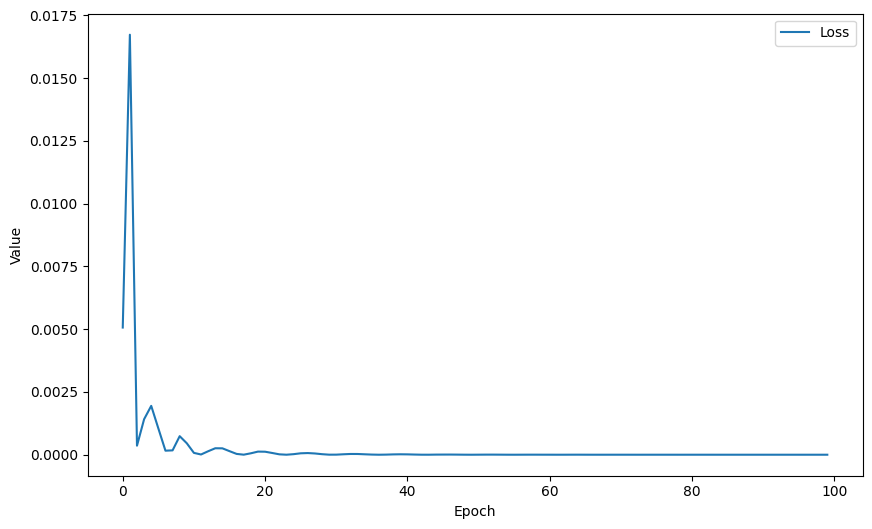

In [93]:
# 绘制预测曲线
plt.figure(figsize=(10, 6))
plt.plot(np.array(losses[:100]), label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

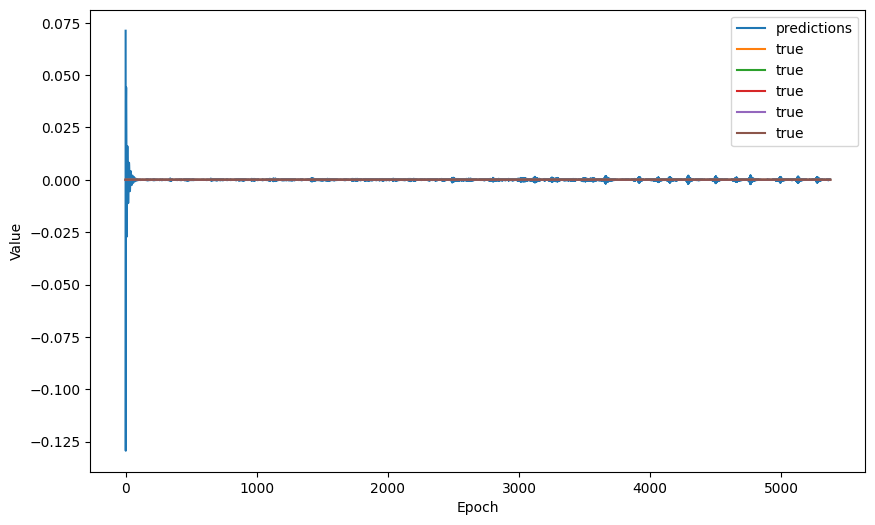

In [94]:
# 绘制预测曲线
plt.figure(figsize=(10, 6))
plt.plot(np.array(predictions), label='predictions')
plt.plot(np.array(true), label='true')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [101]:
predict = []
for epoch in range(200, 237):
    model.eval()
    predict.append(model(g, batch[epoch]))
predict = torch.tensor(predict)

In [107]:
predict[11]

tensor(-0.0001)

In [96]:
torch.tensor(target)
true = []
for i in range(200, 237):
    true.append(target[i])